# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

In this TP, you have to implement a very naive convolutional and max pooling layer. The goal of this TP is not to make you code efficiently this operators (obvisiouly you can and are encouraged to) but to introduce you to this concept.

As usually, write and derive your formulas first in the report! We will be vigilant regarding the correspondence of formulas and code.

Here is a summary of what you will have to do :
- *find* the formulas you need to complete the missing parts of the code, convolution, max pooling, etc. Some of the formulas/operators asked are already familiar to you (ReLu, Linear, etc).
- *report* these formulas in your report
- *implement* the formulas you derive
- *test* if your code works

**LOOPS ARE ALLOWED only in:**
- layers/conv_forward
- layers/conv_backward
- layers/max_pool_forward
- layers/max_pool_backward


In [1]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

from cnn import *
from layers import *
from gradient_check import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# load arrays for tests
npzfile = np.load("arrays_check_true.npz")

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


def check_same_array(array1, array2):
    """ Compares two arrays."""
    # verify shape and content
    if array1.shape == array2.shape and np.isclose(array1, array2, atol=1e-07).all():
        return True
    else:
        return False

## The data

Let's start by uploading the data. In this TP, and since the code you ask you is not optimized, we will work with a very small version of the [mnist](http://yann.lecun.com/exdb/mnist/) dataset.

We have 1797 samples of ten classes (0 to 9), each image is a 8x8 gray scale image and for the purpose of the TP we will transform them in 3x8x8 images. The 3 channels correspond usually for the RGB scheme, here they are simply copies of the original.

Shape of the data: (1797, 3, 8, 8)
Label =  9
Visualization:


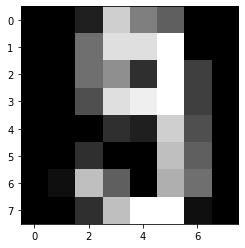

In [2]:
# Load the MNIST data (cropped)

np.random.seed(13)

digits = load_digits()

data = np.array(digits.images)
labels = digits.target

# 3 channel image
data = data[:, None, :, :]
data = np.tile(data, (1, 3, 1, 1))

# normalize between 0 and 1
data /= 16

# shuffle
idx = np.arange(data.shape[0])
np.random.shuffle(idx)

data = data[idx]
labels = labels[idx]

print("Shape of the data:", data.shape)
print("Label = ", labels[0])
print("Visualization:")
plt.imshow(np.moveaxis(data[0], 0, -1))

## Linear layer and ReLu

Before starting with convolutions, we ask you to implement (as warm up) the forward and the backward for the linear layer and the ReLU implement in `layers.py`. 

In [3]:
# Linear: forward
np.random.seed(13)
N = 113
d1 = 32
d2 = 32
D = d1 * d2
M = 64
X = np.random.randn(N, d1, d1)
W = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = linear_forward(X, W, b)
x, w, b = cache
print("(Forward) x shape: {}".format(x.shape))
print("(Forward) w shape: {}".format(w.shape))
print("(Forward) biais shape: {}".format(b.shape))
print("(Forward) out shape: {}".format(out.shape))
if out is None:
    print("You have to implement linear_forward first.")
else:
    if np.abs(out.sum(0).mean() + 64.5087668269637) < 1e-7 \
       and np.abs(out.sum(0).std() - 356.6537542878495) < 1e-7 \
       and np.abs(out.sum(1).mean() + 36.53593873385556) < 1e-7 \
       and np.abs(out.sum(1).std() - 263.5824076112761) < 1e-7:
        print("Great! Your implementation of linear_forward seems good !")
    else:
        print("Bad news! Your implementation of linear_forward seems wrong !")

(Forward) x shape: (113, 32, 32)
(Forward) w shape: (1024, 64)
(Forward) biais shape: (64,)
(Forward) out shape: (113, 64)
Great! Your implementation of linear_forward seems good !


In [4]:
# Linear: backward
np.random.seed(13)
N = 13
d1 = 16
d2 = 16
D = d1 * d2
M = 32
X = np.random.randn(N, d1, d1)
W = np.random.randn(D, M)
b = np.random.randn(M)

dout = np.random.randn(N, M)

out, cache = linear_forward(X, W, b)
x, w, b = cache
print("(Forward) x shape: {}".format(x.shape))
print("(Forward) w shape: {}".format(w.shape))
print("(Forward) biais shape: {}".format(b.shape))
print("(Forward) out shape: {}".format(out.shape))
dx, dw, db = linear_backward(dout, cache)
print("==================")
print("(Backward) dx shape: {}".format(dx.shape))
print("(Backward) dw shape: {}".format(dw.shape))
print("(Backward) db shape: {}".format(db.shape))

if out is None:
    print("You have to implement linear_backward first.")
else:
    dx_num = eval_numerical_gradient_array(lambda X: linear_forward(X, W, b)[0], X, dout)
    dw_num = eval_numerical_gradient_array(lambda W: linear_forward(X, W, b)[0], W, dout)
    db_num = eval_numerical_gradient_array(lambda b: linear_forward(X, W, b)[0], b, dout)
    if rel_error(dx, dx_num) < 1e-7 and rel_error(dw, dw_num) < 1e-6 and rel_error(db, db_num) < 1e-7:
        print("Great! Your implementation of linear_backward seems good !")
    else:
        print("Bad news! Your implementation of linear_backward seems wrong !")

(Forward) x shape: (13, 16, 16)
(Forward) w shape: (256, 32)
(Forward) biais shape: (32,)
(Forward) out shape: (13, 32)
(Backward) dx shape: (13, 16, 16)
(Backward) dw shape: (256, 32)
(Backward) db shape: (32,)
Great! Your implementation of linear_backward seems good !


In [5]:
# ReLu: forward
np.random.seed(13)
N = 113
d1 = 32
d2 = 32
D = d1 * d2
M = 64
X = np.random.randint(-100, 100, size=(N, d1, d1))

out, cache = relu_forward(X)
x = cache
print("(Forward) x shape: {}".format(x.shape))

if out is None:
    print("You have to implement relu_forward first.")
else:
    if check_same_array(out, X - np.minimum(X, 0)):
        print("Great! Your implementation of relu_forward seems good !")
    else:
        print("Bad news! Your implementation of relu_forward seems wrong !")

(Forward) x shape: (113, 32, 32)
Great! Your implementation of relu_forward seems good !


In [6]:
# ReLu: backward
np.random.seed(13)
N = 113
M = 64
X = np.random.randn(N, M)

dout = np.random.randn(N, M)

out, cache = relu_forward(X)
x = cache
print("(Forward) x shape: {}".format(x.shape))
dx = relu_backward(dout, cache)
print("(Backward) dx shape: {}".format(dx.shape))

if out is None:
    print("You have to implement conv_forward first.")
else:
    dx_num = eval_numerical_gradient_array(lambda X: relu_forward(X)[0], X, dout)
    if rel_error(dx, dx_num) < 1e-11:
        print("Great! Your implementation of conv_forward seems good !")
    else:
        print("Bad news! Your implementation of conv_forward seems wrong !")

(Forward) x shape: (113, 64)
(Backward) dx shape: (113, 64)
Great! Your implementation of conv_forward seems good !


# Convolution: forward pass
The core of a convolutional network is the convolution operation. In the file `layers.py`, implement the forward pass for the convolution layer in the function `conv_forward`.

You don't have to worry too much about efficiency; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [7]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward(x, w, b, conv_param)

if out is None:
    print("You have to implement conv_forward first.")
else:
    if check_same_array(out, npzfile['arr_CFN']):
        print("Great! Your implementation of conv_forward seems good !")
    else:
        print("Bad news! Your implementation of conv_forward seems wrong !")

Great! Your implementation of conv_forward seems good !


# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

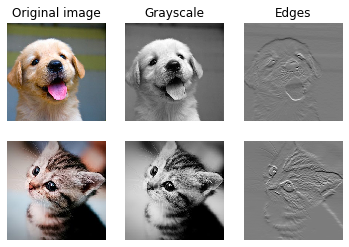

In [8]:
from imageio import imread
from PIL import Image

kitten = imread('notebook_images/kitten.jpg')
puppy = imread('notebook_images/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = np.array(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = np.array(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resized_puppy.transpose((2, 0, 1))
x[1, :, :, :] = resized_kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

# Convolution: backward pass
Implement the backward pass for the convolution operation in the function `conv_backward` in the file `layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [9]:
np.random.seed(13)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_forward(x, w, b, conv_param)
x, w, b, conv_param = cache
print("(Forward) x shape: {}".format(x.shape))
print("(Forward) w shape: {}".format(w.shape))
print("(Forward) biais shape: {}".format(b.shape))
print("(Forward) out shape: {}".format(out.shape))
dx, dw, db = conv_backward(dout, cache)
print("============")
print("Dout shape: {}".format(dout.shape))
print("(Backward) dx shape: {}".format(dx.shape))
print("(Backward) dw shape: {}".format(dw.shape))
print("(Backward) db shape: {}".format(db.shape))

if dx is None or dw is None or db is None:
    print("You have to implement conv_backward first.")
else:
    dx_num = eval_numerical_gradient_array(lambda x: conv_forward(x, w, b, conv_param)[0], x, dout)
    dw_num = eval_numerical_gradient_array(lambda w: conv_forward(x, w, b, conv_param)[0], w, dout)
    db_num = eval_numerical_gradient_array(lambda b: conv_forward(x, w, b, conv_param)[0], b, dout)
    if rel_error(dx, dx_num) < 1e-7 and rel_error(dw, dw_num) < 1e-7 and rel_error(db, db_num) < 1e-7 :
        print("Great! Your implementation of conv_backward seems good !")
    else:
        print("Bad news! Your implementation of conv_backward seems wrong !")

(Forward) x shape: (4, 3, 5, 5)
(Forward) w shape: (2, 3, 3, 3)
(Forward) biais shape: (2,)
(Forward) out shape: (4, 2, 5, 5)
Dout shape: (4, 2, 5, 5)
(Backward) dx shape: (4, 3, 5, 5)
(Backward) dw shape: (2, 3, 3, 3)
(Backward) db shape: (2,)
Great! Your implementation of conv_backward seems good !


# Max-Pooling: forward
Implement the forward pass for the max-pooling operation in the function `max_pool` in the file `layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [10]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward(x, pool_param)

if out is None:
    print("You have to implement max_pool_forward first.")
else:
    if check_same_array(out, npzfile['arr_MPFN']):
        print("Great! Your implementation of max_pool_forward seems good !")
    else:
        print("Bad news! Your implementation of max_pool_forward seems wrong !")

Great! Your implementation of max_pool_forward seems good !


# Max-Pooling: backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward` in the file `layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [11]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = max_pool_forward(x, pool_param)
dx = max_pool_backward(dout, cache)
if dx is None:
    print("You have to implement conv_backward first.")
else:
    dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward(x, pool_param)[0], x, dout)
    if rel_error(dx, dx_num) <= 1e-11:
        print("Great! Your implementation of conv_backward seems good !")
    else:
        print("Bad news! Your implementation of conv_backward seems wrong !")

Great! Your implementation of conv_backward seems good !


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Remember you can use all the layers in the `layers.py` file in your implementation. Run the following cells to help you debug:

## Check forward pass

Here we ask you to build the forward pass of the 3-layer ConvNet. You must follow this architecture:
Convolution -> ReLu -> 2x2 Max Pool -> Linear Layer -> ReLu -> Linear Layer -> Softmax

Don't forget all you need is in the `layers.py` file, even for the backward pass. You can find also combinations of these components. You don't have to compute the softmax because it is already computed in the loss.

In [12]:
np.random.seed(13)
N = 10
X = data[:N]
y = labels[:N]

model = ThreeLayerConvNet(input_dim=(3, 8, 8), num_filters=3, filter_size=3,
                 hidden_dim=10, num_classes=10, weight_scale=1e-3, reg=0.0,
                 dtype=np.float32)
out = model.loss(X)

if out is None:
    print("You have to implement the forward pass first.")
else:
    if check_same_array(out, npzfile['scores_FP']):
        print("Great! Your implementation of the forward pass seems good !")
    else:
        print("Bad news! Your implementation of the forward pass seems wrong !")

Great! Your implementation of the forward pass seems good !


## Check loss

Compute the loss now. We provide you already a funtion that computes the softmax and another for the backward, but since we have a regularization term these simple function is imcomplete. Start from it and add the missing parts on your loss.

In [13]:
np.random.seed(13)
N = 10
X = data[:N]
y = labels[:N]

model = ThreeLayerConvNet(input_dim=(3, 8, 8), num_filters=3, filter_size=3,
                 hidden_dim=10, num_classes=10, weight_scale=1e-3, reg=0.0,
                 dtype=np.float32)

out, _ = model.loss(X, y)
if out is None:
    print("You have to implement the loss (no regularization) first.")
else:
    if check_same_array(out, npzfile['loss_CL']):
        print("Great! Your implementation of the loss (no regularization) seems good !")
    else:
        print("Bad news! Your implementation of the loss (no regularization) seems wrong !")

model.reg = 0.5
out, _ = model.loss(X, y)
if out is None:
    print("You have to implement loss (with regularization) first.")
else:
    if check_same_array(out, npzfile['loss_CLR']):
        print("Great! Your implementation of the loss (with regularization) seems good !")
    else:
        print("Bad news! Your implementation of the loss (with regularization) seems wrong !")

Great! Your implementation of the loss (no regularization) seems good !
Great! Your implementation of the loss (with regularization) seems good !


## Gradient check
After the loss is correct, implement the backward pass. Don't forget that you already implement functions in `layer.py` that may help you know.

In [14]:
np.random.seed(13)
N = 10
X = data[:N]
y = labels[:N]

model = ThreeLayerConvNet(input_dim=(3, 8, 8), num_filters=3, filter_size=3,
                 hidden_dim=10, num_classes=10, weight_scale=1e-3, reg=0.0,
                 dtype=np.float32)


_, out = model.loss(X, y)
if out == {}:
    print("You have to implement grads (no regularization) first.")
else:
    for k, v in out.items():
        if check_same_array(out[k], npzfile['grads_GC_{}'.format(k)]):
            print("Great! Your implementation of the grads (no regularization) for {} seems good !".format(k))
        else:
            print("Bad news! Your implementation of the grads (no regularization) for {} seems wrong !".format(k))

model.reg = 0.5
_, out = model.loss(X, y)
if out  == {}:
    print("You have to implement grads (with regularization) first.")
else:
    for k, v in out.items():
        if check_same_array(out[k], npzfile['grads_GCR_{}'.format(k)]):
            print("Great! Your implementation of the grads (with regularization) for {} seems good !".format(k))
        else:
            print("Bad news! Your implementation of the grads (with regularization) for {} seems wrong !".format(k))


Great! Your implementation of the grads (no regularization) for W1 seems good !
Great! Your implementation of the grads (no regularization) for b1 seems good !
Great! Your implementation of the grads (no regularization) for W2 seems good !
Great! Your implementation of the grads (no regularization) for b2 seems good !
Great! Your implementation of the grads (no regularization) for W3 seems good !
Great! Your implementation of the grads (no regularization) for b3 seems good !
Great! Your implementation of the grads (with regularization) for W1 seems good !
Great! Your implementation of the grads (with regularization) for b1 seems good !
Great! Your implementation of the grads (with regularization) for W2 seems good !
Great! Your implementation of the grads (with regularization) for b2 seems good !
Great! Your implementation of the grads (with regularization) for W3 seems good !
Great! Your implementation of the grads (with regularization) for b3 seems good !


## Train the network

We have almost done. You simply need know to implement SGD in the train function. Don't forget to update all your weights and biases.

The next cell is simply a reduction of the dataset. We reduce the dataset because our implementation of the convolution and myx pooling may not be very optimized, so we have simplyfied the task.

In [15]:
digits_to_keep = [2, 4, 7]

# get indices of elements to keep
idx_to_keep = []
for idx in range(data.shape[0]):
    if labels[idx] in digits_to_keep:
        idx_to_keep.append(True)
    else:
        idx_to_keep.append(False)
        
# get new dataset
data_small = data[idx_to_keep]
labels_small = labels[idx_to_keep].tolist()

# fix indeces
labels_small = np.array([digits_to_keep.index(lab) for lab in labels_small])

N = int(data_small.shape[0]*0.7)
X_train = data_small[:N]
y_train = labels_small[:N]

X_test = data_small[N:]
y_test = labels_small[N:]

Text(0.5, 1.0, 'Loss of 3-layer ConvNet during training')

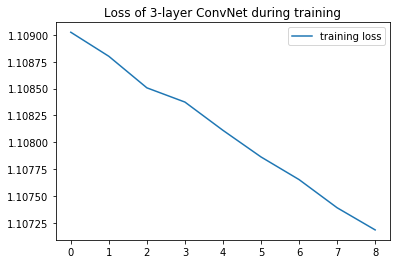

In [16]:
np.random.seed(13)
model = ThreeLayerConvNet(input_dim=(3, 8, 8), num_filters=10, filter_size=3,
                 hidden_dim=128, num_classes=3, weight_scale=1e-3, reg=1,
                 dtype=np.float32)

loss_history, acc_history = model.train(X_train, y_train, batch_size=30, num_epochs=10)

# show the loss

plt.plot(loss_history, label="training loss")
plt.legend()
plt.title("Loss of 3-layer ConvNet during training")


## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

(10, 3, 3, 3)


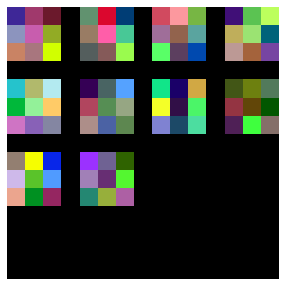

In [17]:
from math import sqrt, ceil

def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

print(model.params['W1'].shape)

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()